### Updates and Imports

In [ ]:
!sudo apt update
!sudo apt autoremove
!sudo apt upgrade
!sudo apt install python3x

In [ ]:
!python --version

import sys
print("version:", sys.version)

In [6]:
!pip install -U pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.2 MB 14.4 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNet,MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

import pandas as pd
import numpy as np
from numpy import newaxis
from sklearn.model_selection import train_test_split
import pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2

In [3]:
from numpy import newaxis
from sklearn.model_selection import train_test_split
import pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2
train_path = "/content/drive/MyDrive/AMLminiproject/train100c5k_v2.pkl"
test_path = "/content/drive/MyDrive/AMLminiproject/test100c5k_nolabel.pkl"
# train_data = open(train_path,'rb')
# test_data = open(test_path,'rb')

In [4]:
# df_train = pd.read_pickle(train_path)
# df_test = pd.read_pickle(test_path)
df_train = pickle.load(open(train_path,'rb'))
df_test = pickle.load(open(test_path,'rb'))
# train_data = df['data'].values

### Mobilenet
reference: https://www.kaggle.com/code/sabarish2611/alexnet-vs-mobilenet-using-mnist-data#AlexNet-vs-MobileNet-:-Comparing-the-performance

In [ ]:
# sampling
sample = df_train.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.3))
sample['data'] = sample['data']/255

In [ ]:
X = np.array(list(sample['data'].values))
# X = np.array([img[:,:,newaxis] for img in np.array(sample['data'].values)])
y = np.array(sample['target'].values)
df_train = None
df_test = None
sample = None
X.shape

(150000, 28, 28)

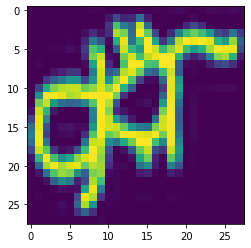

In [ ]:
plt.imshow(X[0])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X = None
y = None
X_train.shape

(112500, 28, 28)

In [ ]:
# X_re = np.zeros((X.shape[0],32,32,3))
# for i in tqdm(range(X.shape[0])):
#     temp = cv2.resize(X[i], dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
#     # temp = temp[:,:,newaxis]
#     # print(temp.shape)
#     img = np.zeros((32,32,3))

#     # print(img.shape)
#     img[:,:,0] = temp
#     img[:,:,1] = temp
#     img[:,:,2] = temp
#     X_re[i] = img
X_train_re = np.zeros((X_train.shape[0],32,32,3))
for i in tqdm(range(X_train.shape[0])):
    temp = cv2.resize(X_train[i], dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
    # temp = temp[:,:,newaxis]
    # print(temp.shape)
    img = np.zeros((32,32,3))

    # print(img.shape)
    img[:,:,0] = temp
    img[:,:,1] = temp
    img[:,:,2] = temp
    X_train_re[i] = img
    X_train[i] = None
X_train = None
X_test_re = np.zeros((X_test.shape[0],32,32,3))
for i in tqdm(range(X_test.shape[0])):
    temp = cv2.resize(X_test[i], dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
    # temp = temp[:,:,newaxis]
    # print(temp.shape)
    img = np.zeros((32,32,3))

    # print(img.shape)
    img[:,:,0] = temp
    img[:,:,1] = temp
    img[:,:,2] = temp
    X_test_re[i] = img
    X_test[i] = None

X_test = None

  0%|          | 0/112500 [00:00<?, ?it/s]

  0%|          | 0/37500 [00:00<?, ?it/s]

In [ ]:
X_train_re.shape

(112500, 32, 32, 3)

In [ ]:
base_model = MobileNet(include_top=False, weights='imagenet',input_shape = (32,32,3), classes=100)
base_model.trainable = True 

for layer in base_model.layers[:50]:
    layer.trainable =  False

MobileNet_model = Sequential()
MobileNet_model.add(base_model)
MobileNet_model.add(Flatten())
MobileNet_model.add(Dense(100,activation=('softmax')))

early_stopping = EarlyStopping(min_delta = 0.001,patience = 20,restore_best_weights = True,verbose = 0)

# Compile
MobileNet_model.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

# Train
Mobile = MobileNet_model.fit(X_train_re, y_train, batch_size = 400, epochs = 50,callbacks = [early_stopping], validation_data = (X_test_re, y_test))

MobileNet_model.summary()

Epoch 1/50
282/282 [==============================] - 22s 34ms/step - loss: 2.3421 - accuracy: 0.4379 - val_loss: 2.2859 - val_accuracy: 0.4241
Epoch 2/50
282/282 [==============================] - 7s 26ms/step - loss: 1.5940 - accuracy: 0.5846 - val_loss: 1.7769 - val_accuracy: 0.5469
Epoch 3/50
282/282 [==============================] - 8s 28ms/step - loss: 1.3610 - accuracy: 0.6362 - val_loss: 1.7431 - val_accuracy: 0.5750
Epoch 4/50
282/282 [==============================] - 7s 27ms/step - loss: 1.2019 - accuracy: 0.6715 - val_loss: 1.6661 - val_accuracy: 0.5821
Epoch 5/50
282/282 [==============================] - 7s 26ms/step - loss: 1.0716 - accuracy: 0.7021 - val_loss: 1.7595 - val_accuracy: 0.5697
Epoch 6/50
282/282 [==============================] - 7s 26ms/step - loss: 0.9593 - accuracy: 0.7280 - val_loss: 1.7388 - val_accuracy: 0.5848
Epoch 7/50
282/282 [==============================] - 7s 26ms/step - loss: 0.8498 - accuracy: 0.7543 - val_loss: 1.8712 - val_accuracy: 0.575

In [ ]:
base_model = MobileNet(include_top=False, weights='imagenet',input_shape = (32,32,3), classes=100)
base_model.trainable = True 

for layer in base_model.layers[:50]:
    layer.trainable =  False

MobileNet_model = Sequential()
MobileNet_model.add(base_model)
MobileNet_model.add(Flatten())
MobileNet_model.add(Dense(100,activation=('softmax')))

early_stopping = EarlyStopping(min_delta = 0.001,patience = 20,restore_best_weights = True,verbose = 0)

# Compile
MobileNet_model.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

# Train
Mobile = MobileNet_model.fit(X_train_re, y_train, batch_size = 400, epochs = 50,callbacks = [early_stopping], validation_data = (X_test_re, y_test))

MobileNet_model.summary()

In [ ]:
MobileNet_model.save('/content/drive/MyDrive/AML mini project/mobile.h5')

In [ ]:
# early_stopping = EarlyStopping(min_delta = 0.001,patience = 20,restore_best_weights = True,verbose = 2)
# model = MobileNet(input_shape=(32, 32, 3), alpha=1., weights=None, classes=100)
# model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
#              metrics=['accuracy'])

# Mobile = model.fit(X_train_re, y_train, batch_size = 400, epochs = 50, callbacks = [early_stopping], validation_data = (X_test_re, y_test))
# print(model.summary())

### LeNet
reference: https://towardsdatascience.com/going-beyond-99-mnist-handwritten-digits-recognition-cfff96337392


In [7]:
train_path = "/content/drive/MyDrive/AMLminiproject/train100c5k_v2.pkl"
test_path = "/content/drive/MyDrive/AMLminiproject/test100c5k_nolabel.pkl"
# train_data = open(train_path,'rb')
# test_data = open(test_path,'rb')

In [11]:
# df_train = pd.read_pickle(train_path)
# df_test = pd.read_pickle(test_path)
df_train = pickle.load(open(train_path,'rb'))
df_test = pickle.load(open(test_path,'rb'))
# train_data = df['data'].values

In [12]:
# sampling
#sample = df_train.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.3))
sample = df_train.copy()
sample['data'] = sample['data']/255

In [13]:
# X = np.array(list(sample['data'].values))
X = np.array([img[:,:,newaxis] for img in np.array(sample['data'].values)])
y = np.array(sample['target'].values)
df_train = None
df_test = None
sample = None
X.shape

(500000, 28, 28, 1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X = None
y = None
X_train.shape

(375000, 28, 28, 1)

In [15]:
X_train.shape

(375000, 28, 28, 1)

In [16]:
X_train_re = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test_re = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_train = None
X_test = None
X_train_re.shape

(375000, 32, 32, 1)

In [ ]:
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

#### LeNet architecture with additional hidden layers and batch normalization followed by them

In [ ]:
model = Sequential([
# Layer 1
Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,1), kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0005)),
# Layer 2
Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False),
# Layer 3
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
MaxPooling2D(pool_size = 2, strides = 2),
Dropout(0.25),
# — — — — — — — — — — — — — — — — #
# Layer 3
Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0005)),
# Layer 4
Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False),
# Layer 5
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
MaxPooling2D(pool_size = 2, strides = 2),
Dropout(0.25),
Flatten(),
# — — — — — — — — — — — — — — — — #
# Layer 6
Dense(units = 256, use_bias=False),
# Layer 7
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
# — — — — — — — — — — — — — — — — #
# Layer 8
Dense(units = 128, use_bias=False),
# Layer 9
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
# — — — — — — — — — — — — — — — — #
# Layer 10
Dense(units = 84, use_bias=False),
# Layer 11
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
Dropout(0.25),
# — — — — — — — — — — — — — — — — #
# Output
Dense(units = 100, activation = 'softmax')
])

In [ ]:
early_stopping = EarlyStopping(min_delta = 0.001,patience = 20,restore_best_weights = True,verbose = 0)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# model.fit(X_train_re, y_train, batch_size = 400, epochs = 50,callbacks = [early_stopping], validation_data = (X_test_re, y_test))
history = model.fit(X_train_re, y_train, epochs = 50, batch_size = 100, callbacks = [early_stopping], validation_data = (X_test_re, y_test))

Epoch 1/50
3750/3750 [==============================] - 54s 11ms/step - loss: 2.2783 - accuracy: 0.4449 - val_loss: 1.6516 - val_accuracy: 0.5801
Epoch 2/50
3750/3750 [==============================] - 42s 11ms/step - loss: 1.6669 - accuracy: 0.5811 - val_loss: 1.4732 - val_accuracy: 0.6205
Epoch 3/50
3750/3750 [==============================] - 35s 9ms/step - loss: 1.5325 - accuracy: 0.6130 - val_loss: 1.3022 - val_accuracy: 0.6662
Epoch 4/50
3750/3750 [==============================] - 33s 9ms/step - loss: 1.4575 - accuracy: 0.6315 - val_loss: 1.2603 - val_accuracy: 0.6777
Epoch 5/50
3750/3750 [==============================] - 35s 9ms/step - loss: 1.4107 - accuracy: 0.6435 - val_loss: 1.2330 - val_accuracy: 0.6849
Epoch 6/50
3750/3750 [==============================] - 34s 9ms/step - loss: 1.3774 - accuracy: 0.6511 - val_loss: 1.2859 - val_accuracy: 0.6710
Epoch 7/50
3750/3750 [==============================] - 33s 9ms/step - loss: 1.3474 - accuracy: 0.6589 - val_loss: 1.1728 - val_

In [ ]:
model.save('/content/drive/MyDrive/AML mini project/lenet.h5')

In [ ]:
save_path = '/content/drive/MyDrive/AML mini project/lenet.h5'
model.save(save_path,save_format='tf')

In [20]:
save_path = '/content/drive/MyDrive/AMLminiproject/lenet.h5'
model = tf.keras.models.load_model(save_path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25600     
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0

In [ ]:
# training for more 50 epochs i.e total of 100 epochs
early_stopping = EarlyStopping(min_delta = 0.001,patience = 20,restore_best_weights = True,verbose = 0)

history = model.fit(X_train_re, y_train, epochs = 50, batch_size = 100, callbacks = [early_stopping], validation_data = (X_test_re, y_test))

Epoch 1/50
3750/3750 [==============================] - 47s 10ms/step - loss: 1.1188 - accuracy: 0.7156 - val_loss: 1.0998 - val_accuracy: 0.7250
Epoch 2/50
3750/3750 [==============================] - 32s 9ms/step - loss: 1.1188 - accuracy: 0.7154 - val_loss: 1.0536 - val_accuracy: 0.7333
Epoch 3/50
3750/3750 [==============================] - 36s 10ms/step - loss: 1.1176 - accuracy: 0.7152 - val_loss: 1.0578 - val_accuracy: 0.7320
Epoch 4/50
3750/3750 [==============================] - 34s 9ms/step - loss: 1.1138 - accuracy: 0.7159 - val_loss: 1.0859 - val_accuracy: 0.7266
Epoch 5/50
3750/3750 [==============================] - 32s 9ms/step - loss: 1.1124 - accuracy: 0.7159 - val_loss: 1.0568 - val_accuracy: 0.7334
Epoch 6/50
3750/3750 [==============================] - 33s 9ms/step - loss: 1.1119 - accuracy: 0.7168 - val_loss: 1.0853 - val_accuracy: 0.7261
Epoch 7/50
3750/3750 [==============================] - 34s 9ms/step - loss: 1.1092 - accuracy: 0.7173 - val_loss: 1.0525 - val_

In [ ]:
save_path = '/content/drive/MyDrive/AML mini project/lenet_100e.h5'
model.save(save_path,save_format='tf')

In [ ]:
save_path = '/content/drive/MyDrive/AML mini project/lenet.h5'
model = tf.keras.models.load_model(save_path)

In [17]:
# we can see that the best fit is around 75 epochs, hence we will train the 50 epoch model for mre 25 epochs total of 75
history = model.fit(X_train_re, y_train, epochs = 25, batch_size = 100, validation_data = (X_test_re, y_test))

NameError: ignored

In [ ]:
save_path = '/content/drive/MyDrive/AML mini project/lenet_75e.h5'
model.save(save_path,save_format='tf')

In [ ]:
# df_test['data'] = df_test['data']/255
df_test.head()

,data
0,"[[0, 0, 0, 4, 4, 0, 0, 3, 5, 2, 0, 0, 11, 0, 0..."
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[0, 3, 0, 0, 101, 128, 21, 0, 10, 4, 3, 2, 2,..."
3,"[[0, 12, 55, 101, 116, 98, 79, 66, 52, 39, 30,..."
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
df_test['data'] = df_test['data']/255

In [ ]:
df_test.head()

AttributeError: ignored

In [ ]:
test_data = np.array([img[:,:,newaxis] for img in np.array(df_test['data'].values)])
test_data.shape

(100000, 28, 28, 1)

In [ ]:
X_test_data = np.pad(test_data, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test_data.shape

(100000, 32, 32, 1)

In [ ]:
save_path = '/content/drive/MyDrive/AML mini project/lenet_75e.h5'
model = tf.keras.models.load_model(save_path)

In [ ]:
X_test_data[0].shape

(32, 32, 1)

In [ ]:
y_pred = model.predict(X_test_data)

3125/3125 [==============================] - 7s 2ms/step


In [ ]:
results = np.argmax(y_pred,axis = 1)
results

array([77, 50, 80, ..., 63,  0, 22])

### Trying modifying LeNet architecture
Increase batch size 

In [ ]:
model = Sequential([
# Layer 1
Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,1), kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0005)),
# Layer 2
Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False),
# Layer 3
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
MaxPooling2D(pool_size = 2, strides = 2),
Dropout(0.25),
# — — — — — — — — — — — — — — — — #
# Layer 3
Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0005)),
# Layer 4
Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False),
# Layer 5
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
MaxPooling2D(pool_size = 2, strides = 2),
Dropout(0.25),
Flatten(),
# — — — — — — — — — — — — — — — — #
# Layer 6
Dense(units = 320, use_bias=False),
# Layer 7
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
# — — — — — — — — — — — — — — — — #
# Layer 8
Dense(units = 160, use_bias=False),
# Layer 9
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
# — — — — — — — — — — — — — — — — #
# Layer 10
Dense(units = 128, use_bias=False),
# Layer 11
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
Dropout(0.25),
# — — — — — — — — — — — — — — — — #
# Output
Dense(units = 100, activation = 'softmax')
])

In [ ]:
early_stopping = EarlyStopping(min_delta = 0.001,patience = 20,restore_best_weights = True,verbose = 0)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# model.fit(X_train_re, y_train, batch_size = 400, epochs = 50,callbacks = [early_stopping], validation_data = (X_test_re, y_test))
history = model.fit(X_train_re, y_train, epochs = 50, batch_size = 150, callbacks = [early_stopping], validation_data = (X_test_re, y_test))

Epoch 1/50
2500/2500 [==============================] - 41s 13ms/step - loss: 2.2116 - accuracy: 0.4587 - val_loss: 1.5957 - val_accuracy: 0.5915
Epoch 2/50
2500/2500 [==============================] - 32s 13ms/step - loss: 1.5810 - accuracy: 0.5981 - val_loss: 1.3743 - val_accuracy: 0.6450
Epoch 3/50
2500/2500 [==============================] - 30s 12ms/step - loss: 1.4423 - accuracy: 0.6323 - val_loss: 1.2739 - val_accuracy: 0.6710
Epoch 4/50
2500/2500 [==============================] - 30s 12ms/step - loss: 1.3668 - accuracy: 0.6505 - val_loss: 1.1954 - val_accuracy: 0.6905
Epoch 5/50
2500/2500 [==============================] - 31s 12ms/step - loss: 1.3173 - accuracy: 0.6633 - val_loss: 1.2172 - val_accuracy: 0.6856
Epoch 6/50
2500/2500 [==============================] - 29s 12ms/step - loss: 1.2796 - accuracy: 0.6715 - val_loss: 1.1713 - val_accuracy: 0.6970
Epoch 7/50
2500/2500 [==============================] - 31s 12ms/step - loss: 1.2501 - accuracy: 0.6787 - val_loss: 1.1428 -

#### Trying to change neurons in hidden layers

In [ ]:
model = Sequential([
# Layer 1
Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,1), kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0005)),
# Layer 2
Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False),
# Layer 3
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
MaxPooling2D(pool_size = 2, strides = 2),
Dropout(0.25),
# — — — — — — — — — — — — — — — — #
# Layer 3
Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0005)),
# Layer 4
Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False),
# Layer 5
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
MaxPooling2D(pool_size = 2, strides = 2),
Dropout(0.25),
Flatten(),
# — — — — — — — — — — — — — — — — #
# Layer 6
Dense(units = 256, use_bias=False),
# Layer 7
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
# — — — — — — — — — — — — — — — — #
# Layer 10
Dense(units = 128, use_bias=False),
# Layer 11
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
Dropout(0.25),
# — — — — — — — — — — — — — — — — #
# Output
Dense(units = 100, activation = 'softmax')
])

In [ ]:
early_stopping = EarlyStopping(min_delta = 0.001,patience = 20,restore_best_weights = True,verbose = 0)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model.fit(X_train_re, y_train, batch_size = 400, epochs = 50,callbacks = [early_stopping], validation_data = (X_test_re, y_test))
history = model.fit(X_train_re, y_train, epochs = 50, batch_size = 150, callbacks = [early_stopping], validation_data = (X_test_re, y_test))

Epoch 1/50
2500/2500 [==============================] - 31s 12ms/step - loss: 2.2103 - accuracy: 0.4587 - val_loss: 1.6014 - val_accuracy: 0.5920
Epoch 2/50
2500/2500 [==============================] - 29s 12ms/step - loss: 1.5995 - accuracy: 0.5932 - val_loss: 1.3521 - val_accuracy: 0.6519
Epoch 3/50
2500/2500 [==============================] - 30s 12ms/step - loss: 1.4686 - accuracy: 0.6246 - val_loss: 1.3037 - val_accuracy: 0.6650
Epoch 4/50
2500/2500 [==============================] - 28s 11ms/step - loss: 1.3992 - accuracy: 0.6420 - val_loss: 1.3229 - val_accuracy: 0.6599
Epoch 5/50
2500/2500 [==============================] - 28s 11ms/step - loss: 1.3533 - accuracy: 0.6536 - val_loss: 1.2024 - val_accuracy: 0.6896
Epoch 6/50
2500/2500 [==============================] - 28s 11ms/step - loss: 1.3196 - accuracy: 0.6615 - val_loss: 1.1897 - val_accuracy: 0.6926
Epoch 7/50
2500/2500 [==============================] - 28s 11ms/step - loss: 1.2899 - accuracy: 0.6685 - val_loss: 1.1597 -

In [ ]:
save_path = '/content/drive/MyDrive/AML mini project/lenet_50e_150b_2.h5'
model.save(save_path,save_format='tf')

#### Reduce batch size back to 100, with new architecture(modified hidden layers)

In [ ]:
model = Sequential([
# Layer 1
Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,1), kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0005)),
# Layer 2
Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False),
# Layer 3
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
MaxPooling2D(pool_size = 2, strides = 2),
Dropout(0.25),
# — — — — — — — — — — — — — — — — #
# Layer 3
Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0005)),
# Layer 4
Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False),
# Layer 5
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
MaxPooling2D(pool_size = 2, strides = 2),
Dropout(0.25),
Flatten(),
# — — — — — — — — — — — — — — — — #
# Layer 6
Dense(units = 256, use_bias=False),
# Layer 7
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
# — — — — — — — — — — — — — — — — #
# Layer 10
Dense(units = 128, use_bias=False),
# Layer 11
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
Dropout(0.25),
# — — — — — — — — — — — — — — — — #
# Output
Dense(units = 100, activation = 'softmax')
])

In [ ]:
early_stopping = EarlyStopping(min_delta = 0.001,patience = 20,restore_best_weights = True,verbose = 0)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model.fit(X_train_re, y_train, batch_size = 400, epochs = 50,callbacks = [early_stopping], validation_data = (X_test_re, y_test))
history = model.fit(X_train_re, y_train, epochs = 50, batch_size = 100, callbacks = [early_stopping], validation_data = (X_test_re, y_test))

Epoch 1/50
3750/3750 [==============================] - 43s 9ms/step - loss: 2.1532 - accuracy: 0.4711 - val_loss: 1.5326 - val_accuracy: 0.6105
Epoch 2/50
3750/3750 [==============================] - 32s 8ms/step - loss: 1.6008 - accuracy: 0.5934 - val_loss: 1.3645 - val_accuracy: 0.6505
Epoch 3/50
3750/3750 [==============================] - 31s 8ms/step - loss: 1.4787 - accuracy: 0.6228 - val_loss: 1.2879 - val_accuracy: 0.6712
Epoch 4/50
3750/3750 [==============================] - 31s 8ms/step - loss: 1.4118 - accuracy: 0.6392 - val_loss: 1.2095 - val_accuracy: 0.6888
Epoch 5/50
3750/3750 [==============================] - 33s 9ms/step - loss: 1.3690 - accuracy: 0.6508 - val_loss: 1.1964 - val_accuracy: 0.6921
Epoch 6/50
3750/3750 [==============================] - 31s 8ms/step - loss: 1.3377 - accuracy: 0.6578 - val_loss: 1.1704 - val_accuracy: 0.6999
Epoch 7/50
3750/3750 [==============================] - 34s 9ms/step - loss: 1.3142 - accuracy: 0.6641 - val_loss: 1.1578 - val_ac

In [ ]:
save_path = '/content/drive/MyDrive/AML mini project/lenet_50e_100b_1.h5'
model.save(save_path,save_format='tf')

#### Adding one more hidden layer

In [ ]:
model = Sequential([
# Layer 1
Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,1), kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0005)),
# Layer 2
Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False),
# Layer 3
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
MaxPooling2D(pool_size = 2, strides = 2),
Dropout(0.25),
# — — — — — — — — — — — — — — — — #
# Layer 3
Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=0.0005)),
# Layer 4
Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False),
# Layer 5
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
MaxPooling2D(pool_size = 2, strides = 2),
Dropout(0.25),
Flatten(),
# — — — — — — — — — — — — — — — — #
# Layer 6
Dense(units = 256, use_bias=False),
# Layer 7
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
# — — — — — — — — — — — — — — — — #
# Layer 8
Dense(units = 186, use_bias=False),
# Layer 9
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
# — — — — — — — — — — — — — — — — #
# Layer 10
Dense(units = 128, use_bias=False),
# Layer 11
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
# — — — — — — — — — — — — — — — — #
# Layer 12
Dense(units = 84, use_bias=False),
# Layer 13
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
Dropout(0.25),
# — — — — — — — — — — — — — — — — #
# Output
Dense(units = 100, activation = 'softmax')
])

In [ ]:
early_stopping = EarlyStopping(min_delta = 0.001,patience = 20,restore_best_weights = True,verbose = 0)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# model.fit(X_train_re, y_train, batch_size = 400, epochs = 50,callbacks = [early_stopping], validation_data = (X_test_re, y_test))
history = model.fit(X_train_re, y_train, epochs = 50, batch_size = 100, callbacks = [early_stopping], validation_data = (X_test_re, y_test))

Epoch 1/50
3750/3750 [==============================] - 38s 10ms/step - loss: 2.3009 - accuracy: 0.4401 - val_loss: 1.5902 - val_accuracy: 0.5925
Epoch 2/50
3750/3750 [==============================] - 34s 9ms/step - loss: 1.6725 - accuracy: 0.5796 - val_loss: 1.4001 - val_accuracy: 0.6415
Epoch 3/50
3750/3750 [==============================] - 34s 9ms/step - loss: 1.5302 - accuracy: 0.6150 - val_loss: 1.3544 - val_accuracy: 0.6550
Epoch 4/50
3750/3750 [==============================] - 34s 9ms/step - loss: 1.4518 - accuracy: 0.6347 - val_loss: 1.3184 - val_accuracy: 0.6616
Epoch 5/50
3750/3750 [==============================] - 34s 9ms/step - loss: 1.3979 - accuracy: 0.6478 - val_loss: 1.2264 - val_accuracy: 0.6860
Epoch 6/50
3750/3750 [==============================] - 34s 9ms/step - loss: 1.3604 - accuracy: 0.6581 - val_loss: 1.1936 - val_accuracy: 0.6949
Epoch 7/50
3750/3750 [==============================] - 34s 9ms/step - loss: 1.3326 - accuracy: 0.6646 - val_loss: 1.1751 - val_a

In [ ]:
save_path = '/content/drive/MyDrive/AML mini project/lenet_50e_dense.h5'
model.save(save_path,save_format='tf')

In [ ]:
X_train_re = None

### Predictions

In [5]:
df_test = pickle.load(open(test_path,'rb'))
df_test['data'] = df_test['data']/255
df_test.head()

,data
0,"[[0.0, 0.0, 0.0, 0.01568627450980392, 0.015686..."
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,"[[0.0, 0.011764705882352941, 0.0, 0.0, 0.39607..."
3,"[[0.0, 0.047058823529411764, 0.215686274509803..."
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [6]:
test_data = np.array([img[:,:,newaxis] for img in np.array(df_test['data'].values)])
test_data.shape

(100000, 28, 28, 1)

In [7]:
X_test_data = np.pad(test_data, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test_data.shape

(100000, 32, 32, 1)

In [9]:
save_path = '/content/drive/MyDrive/AMLminiproject/lenet_75e.h5'
model = tf.keras.models.load_model(save_path)
y_pred = model.predict(X_test_data)

3125/3125 [==============================] - 119s 38ms/step


In [10]:
results = np.argmax(y_pred,axis = 1)
results

array([77, 50, 80, ..., 63,  0, 22])

In [12]:
with open('/content/drive/MyDrive/AMLminiproject/project_rsheta.txt', 'w') as file:  # edit here as your username
    file.write('\n'.join(map(str, results)))
    file.flush()

In [ ]:
y_pred = model.predict(X_test_re)

3907/3907 [==============================] - 10s 2ms/step


In [ ]:
results = np.argmax(y_pred,axis = 1)
results.shape

(125000,)

In [ ]:
y_test_new = np.argmax(y_test,axis = 1)
y_test_new.shape

(125000,)

In [ ]:
from sklearn.metrics import accuracy_score



In [ ]:
accuracy_score(y_test_new, results)

0.731992

In [ ]:
y_test_new[:5]

array([20, 39, 28, 26, 81])

In [ ]:
results[:5]

array([51, 39, 28, 26, 81])